In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 0. Data Exploration

In [52]:
df = pd.read_csv("KPIs sample 5 cells data_train.csv",delimiter=";")
df.head()

,index,cell_id,DL_TRAFFIC_VOLUME,UL_TRAFFIC_VOLUME,Inter_X2_based_HO_prep,PDCP_SDU_Volume_DL,VoLTE_total_traffic,INTRA_FREQ_HO_SR_RATIO,RRC_SR_RATIO,Intra_eNB_HO_SR_total_RATIO,...,E_RAB_QCI1_DR_RATIO,DCR_LTE_RATIO,CSSR_LTE_RATIO,LTE_INTER_ENODEB_HOSR_RATIO,E_UTRAN_Inter_Freq_HO_SR_RATIO,Inter_RAT_HO_SR_GERAN_SRVCC_RATIO,Inter_RAT_Total_HO_SR_RATIO,E_UTRAN_tot_HO_SR_inter_eNB_X2_RATIO,DL_THROUGHPUT_RATIO,E_RAB_DR_RATIO
0,09/05/2021 00:00,2.226537e+17,3.779737e+10,3.947172e+09,15.0,3.779737e+10,4727.0,0.809859,0.992427,0.809859,...,0.000000,0.001761,0.996041,0.400000,0.770642,0.963636,0.963636,0.400000,82.550417,0.001761
1,09/05/2021 01:00,2.226537e+17,3.684898e+10,4.088752e+09,6.0,3.684898e+10,3076.0,0.886792,0.993288,0.886792,...,0.000000,0.002468,0.995465,0.500000,0.842105,1.000000,1.000000,0.500000,80.531811,0.002468
2,09/05/2021 02:00,2.226537e+17,3.292677e+10,5.016897e+09,8.0,3.292677e+10,3501.0,0.938356,0.994664,0.938356,...,0.013889,0.003077,0.996044,0.375000,0.931624,1.000000,0.966667,0.375000,71.885311,0.003077
3,09/05/2021 03:00,2.226537e+17,3.021547e+10,5.139107e+09,9.0,3.021547e+10,2275.0,0.860215,0.994819,0.860215,...,0.000000,0.001721,0.995920,0.777778,0.816901,0.947368,0.947368,0.777778,65.977430,0.001721
4,09/05/2021 04:00,2.226537e+17,3.082176e+10,4.250716e+09,17.0,3.082176e+10,2178.0,0.840426,0.995952,0.840426,...,0.000000,0.002213,0.995628,0.764706,0.794521,1.000000,1.000000,0.764706,67.324805,0.002213


In [131]:
# Check the number of records
len(df)

8280

In [15]:
# Check cell_id count
df["cell_id"].value_counts()

9.106218e+16    1656
2.226537e+17    1656
3.844733e+17    1656
4.262775e+17    1656
7.315874e+16    1656
Name: cell_id, dtype: int64

In [18]:
# Check data type
df.dtypes

index                                                       object
cell_id                                                    float64
DL_TRAFFIC_VOLUME                                          float64
UL_TRAFFIC_VOLUME                                          float64
Inter_X2_based_HO_prep                                     float64
PDCP_SDU_Volume_DL                                         float64
VoLTE_total_traffic                                        float64
INTRA_FREQ_HO_SR_RATIO                                     float64
RRC_SR_RATIO                                               float64
Intra_eNB_HO_SR_total_RATIO                                float64
E_UTRAN_RRC_Conn_Stp_Failure_due_RRC_timer_expiry_RATIO    float64
CELL_AVAILABILITY_RATIO                                    float64
RACH_Stp_Completion_SR_RATIO                               float64
Total_E_UTRAN_RRC_Conn_Stp_SR_RATIO                        float64
Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO                          flo

In [10]:
# Check number of null value in each column 
df.isnull().sum(axis=0)

index                                                         0
cell_id                                                       0
DL_TRAFFIC_VOLUME                                            21
UL_TRAFFIC_VOLUME                                            21
Inter_X2_based_HO_prep                                     3313
PDCP_SDU_Volume_DL                                         3313
VoLTE_total_traffic                                        3313
INTRA_FREQ_HO_SR_RATIO                                       40
RRC_SR_RATIO                                                 28
Intra_eNB_HO_SR_total_RATIO                                3321
E_UTRAN_RRC_Conn_Stp_Failure_due_RRC_timer_expiry_RATIO    3313
CELL_AVAILABILITY_RATIO                                      20
RACH_Stp_Completion_SR_RATIO                               3313
Total_E_UTRAN_RRC_Conn_Stp_SR_RATIO                        3313
Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO                          5595
UL_THROUGHPUT_RATIO                     

## Check infinite values

In [70]:
# remove "index" and "cell_id" 
features = df.drop(["index","cell_id"],axis=1)

# print out infinite value counts
print("n_infinite \t feature_name")
for feature in features.columns: 
    n_inf = np.isinf(features[feature]).sum()
    print(str(n_inf) + "\t\t" +feature)

n_infinite 	 feature_name
0		DL_TRAFFIC_VOLUME
0		UL_TRAFFIC_VOLUME
0		Inter_X2_based_HO_prep
0		PDCP_SDU_Volume_DL
0		VoLTE_total_traffic
0		INTRA_FREQ_HO_SR_RATIO
0		RRC_SR_RATIO
0		Intra_eNB_HO_SR_total_RATIO
0		E_UTRAN_RRC_Conn_Stp_Failure_due_RRC_timer_expiry_RATIO
0		CELL_AVAILABILITY_RATIO
0		RACH_Stp_Completion_SR_RATIO
0		Total_E_UTRAN_RRC_Conn_Stp_SR_RATIO
1		Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO
0		UL_THROUGHPUT_RATIO
0		E_RAB_QCI1_DR_RATIO
0		DCR_LTE_RATIO
0		CSSR_LTE_RATIO
0		LTE_INTER_ENODEB_HOSR_RATIO
0		E_UTRAN_Inter_Freq_HO_SR_RATIO
0		Inter_RAT_HO_SR_GERAN_SRVCC_RATIO
0		Inter_RAT_Total_HO_SR_RATIO
0		E_UTRAN_tot_HO_SR_inter_eNB_X2_RATIO
0		DL_THROUGHPUT_RATIO
0		E_RAB_DR_RATIO


In [86]:
condition = features["Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO"]==np.inf
features = features.drop(features[condition].index)

In [132]:
len(features)

8279

**Plot the distribution of each feature**

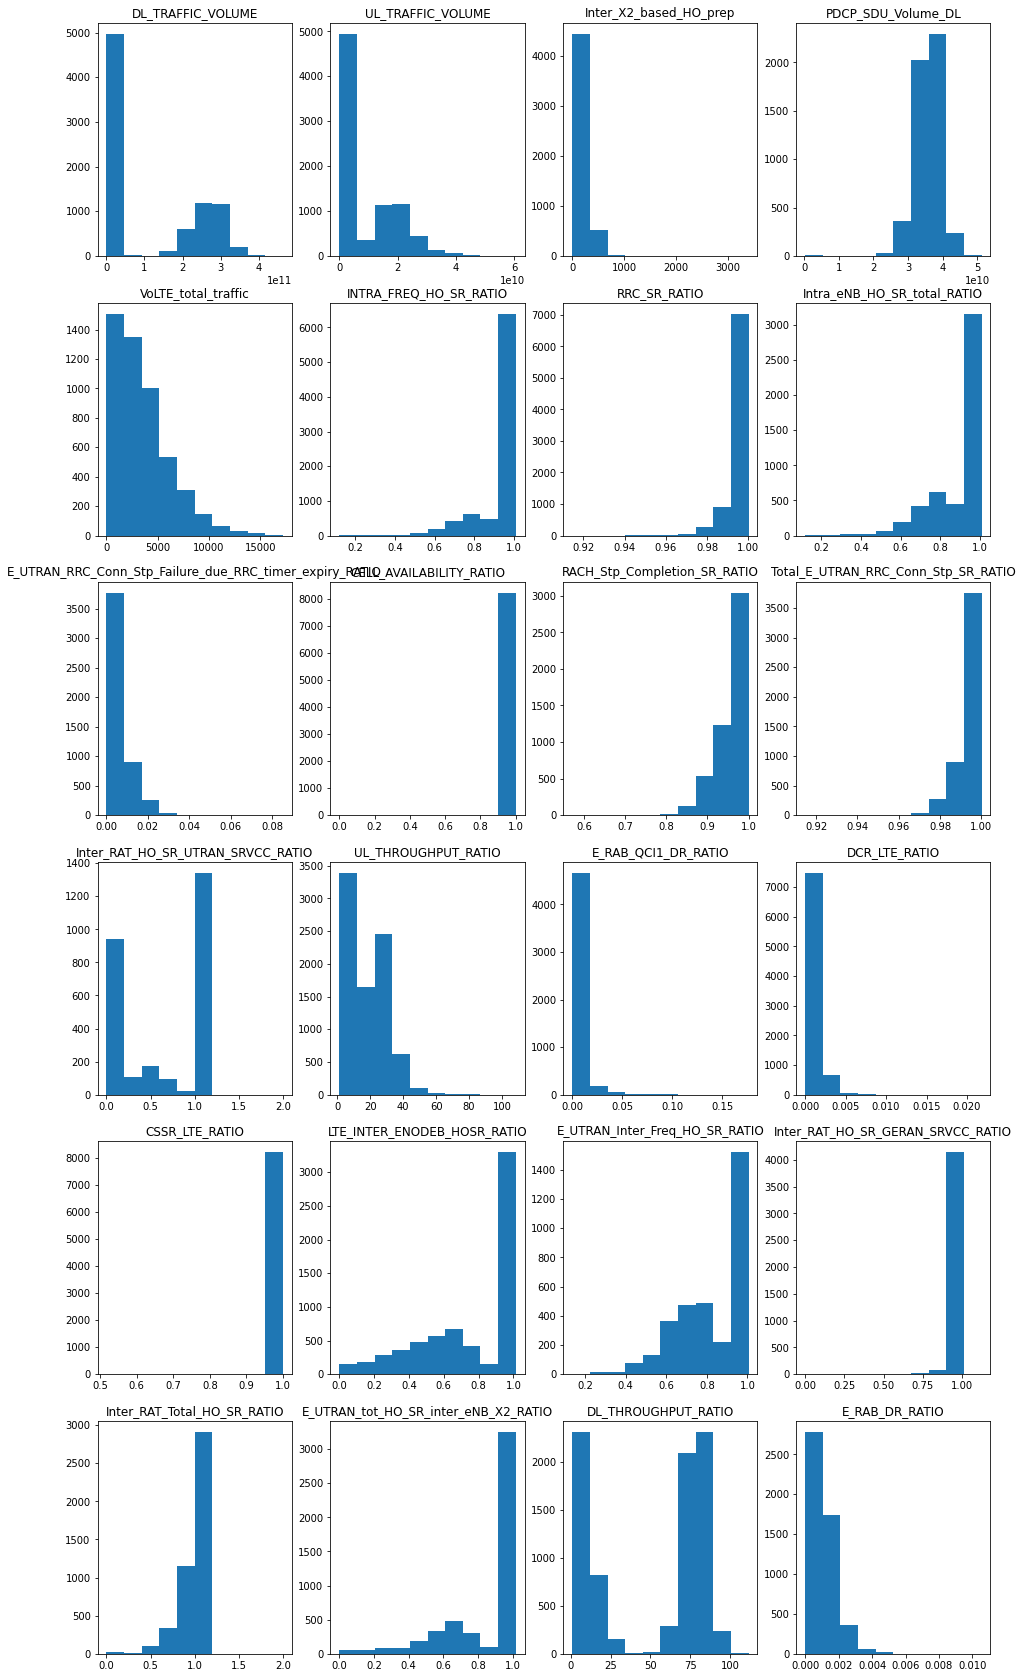

In [84]:
import math 

feature_names = features.columns
feature_nb = len(feature_names)

# plot the distribution of each feature
n_per_row = 4
n_rows = math.ceil(feature_nb/n_per_row)

def get_fig_position(i,n_per_row):
    row = i/n_per_row
    col = i%n_per_row
    return int(row),int(col)

# plot hist
fig,ax = plt.subplots(n_rows,n_per_row,figsize=[4*n_per_row,5*n_rows])
for i,name in enumerate(feature_names):
    ix,iy = get_fig_position(i,n_per_row)
    axes = ax[ix][iy]
    feature = features[name].dropna()
    axes.set_title(name)
    axes.hist(feature)
plt.show()

In [127]:
null_cols = [   #1695
                "LTE_INTER_ENODEB_HOSR_RATIO", 
                  
                  #3313
                  "Inter_X2_based_HO_prep", 
                  "PDCP_SDU_Volume_DL",
                  "VoLTE_total_traffic",
                  "RACH_Stp_Completion_SR_RATIO",
                  "E_UTRAN_RRC_Conn_Stp_Failure_due_RRC_timer_expiry_RATIO",
                  "Total_E_UTRAN_RRC_Conn_Stp_SR_RATIO",
                  
                 "E_RAB_DR_RATIO", 
    
                 "Intra_eNB_HO_SR_total_RATIO", #6~8个不为空
                 "E_RAB_QCI1_DR_RATIO", # 10
                 "E_UTRAN_tot_HO_SR_inter_eNB_X2_RATIO", # 14个
                  
                 "Inter_RAT_Total_HO_SR_RATIO", #E_UTRAN 48个 其余1
    
                  # 后面很多 100+
                  "Inter_RAT_HO_SR_GERAN_SRVCC_RATIO",
                  "E_UTRAN_Inter_Freq_HO_SR_RATIO",
                  "Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO"]


In [130]:
df_check = features[features["Inter_X2_based_HO_prep"].isnull()]
df_check[null_cols].describe()

,Inter_RAT_Total_HO_SR_RATIO,Inter_RAT_HO_SR_GERAN_SRVCC_RATIO,E_UTRAN_Inter_Freq_HO_SR_RATIO,Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO
count,1284.000000,1045.000000,0.0,985.000000
mean,0.958340,0.997129,NaN,0.914455
std,0.134512,0.032782,NaN,0.223298
min,0.000000,0.333333,NaN,0.000000
25%,1.000000,1.000000,NaN,1.000000
50%,1.000000,1.000000,NaN,1.000000
75%,1.000000,1.000000,NaN,1.000000
max,2.000000,1.000000,NaN,2.000000


# 1. Data preprocessing

## 1.1 Null values

In [89]:
# Check number of null value in each column 
features.isnull().sum(axis=0)

DL_TRAFFIC_VOLUME                                            21
UL_TRAFFIC_VOLUME                                            21
Inter_X2_based_HO_prep                                     3313
PDCP_SDU_Volume_DL                                         3313
VoLTE_total_traffic                                        3313
INTRA_FREQ_HO_SR_RATIO                                       40
RRC_SR_RATIO                                                 28
Intra_eNB_HO_SR_total_RATIO                                3321
E_UTRAN_RRC_Conn_Stp_Failure_due_RRC_timer_expiry_RATIO    3313
CELL_AVAILABILITY_RATIO                                      20
RACH_Stp_Completion_SR_RATIO                               3313
Total_E_UTRAN_RRC_Conn_Stp_SR_RATIO                        3313
Inter_RAT_HO_SR_UTRAN_SRVCC_RATIO                          5595
UL_THROUGHPUT_RATIO                                          28
E_RAB_QCI1_DR_RATIO                                        3324
DCR_LTE_RATIO                           

In [ ]:
df_test

In [ ]:
model=IsolationForest(n_estimators=50, 
                      max_samples='auto', 
                      contamination=float(0.1),
                      max_features=1.0)
model.fit(features)